In [241]:
import pandas as pd

In [242]:
import cortex

In [243]:
import glob

In [244]:
import re
reg = re.compile('.*/sub-(?P<subject>.+)/ses-(?P<session>.+)/func/sub-(.+)_ses-.+_hemi-(?P<hemi>lh|rh)_energies\.pkl')

In [245]:
fns = glob.glob('/data/odc/derivatives/zmap_spatfreq/sub-*/ses-*/func/sub-*_ses-*_hemi-*_energies.pkl')

In [246]:
def get_vertex_mask(subject, hemi='lh', roi='V1'):
    
    
    if hemi == 'lh':
        mask = cortex.utils.get_roi_verts('odc.{}'.format(subject), roi=roi+'l')[roi+hemi[:1]]
    elif hemi == 'rh':
        left_pts, _ = cortex.db.get_surf('odc.{}'.format(subject), hemisphere='left', type='fiducial')
        mask = cortex.utils.get_roi_verts('odc.{}'.format(subject), roi=roi+'r')[roi+hemi[:1]]
        mask -= len(left_pts)
        
    return mask

In [247]:
energies = []
idx = []

for fn in fns:
    e = pd.read_pickle(fn)    

    meta = reg.match(fn).groupdict()    
    mask = get_vertex_mask(meta['subject'], meta['hemi'])
    
    ix = e.columns.intersection(mask)
    
    e = e.loc[:, ix]    
    print('{}/{} V1 vertices have energy ({}, {})'.format(len(ix), len(mask), meta['subject'], meta['session'], meta['hemi']))
    
    idx.append(meta)
    
    energies.append(e)
    
# energies = pd.concat(energies, axis=0)

5057/6597 V1 vertices have energy (bm, odc)
4478/4628 V1 vertices have energy (bm, odc)
6369/9503 V1 vertices have energy (eo, odc)
6232/8879 V1 vertices have energy (eo, odc)
4999/7012 V1 vertices have energy (ms, odc2)
4640/6888 V1 vertices have energy (ms, odc2)
7335/9560 V1 vertices have energy (ns, odc)
5597/9847 V1 vertices have energy (ns, odc)
5750/5771 V1 vertices have energy (tk, odc2)
6180/6746 V1 vertices have energy (tk, odc2)
5750/5771 V1 vertices have energy (tk, odc3)
6180/6746 V1 vertices have energy (tk, odc3)
9629/9629 V1 vertices have energy (tr, odc)
10682/10898 V1 vertices have energy (tr, odc)


In [248]:
energies = pd.concat(energies, 
                     keys=[(d['subject'], d['session'], d['hemi']) for d in idx], 
                     names=['subject', 'session', 'hemi', 'vertex'],
                     axis=1)

In [249]:
fns = glob.glob('/data/odc/derivatives/')

In [250]:
max_frequency = energies.groupby(['depth', 'frequency']).sum().groupby('depth', as_index=True).apply(lambda d: d.reset_index('depth', drop=True).idxmax())

In [251]:
max_wl = 1. / max_frequency

In [252]:
import seaborn as sns

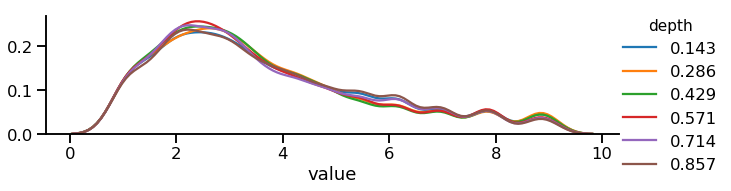

In [253]:
tmp = max_wl.iloc[:, ::5].reset_index().melt(id_vars='depth', var_name='vertex')
fac = sns.FacetGrid(tmp[tmp.value < 10], hue='depth', aspect=3)
fac.map(sns.distplot, 'value', hist=False)
fac.add_legend()

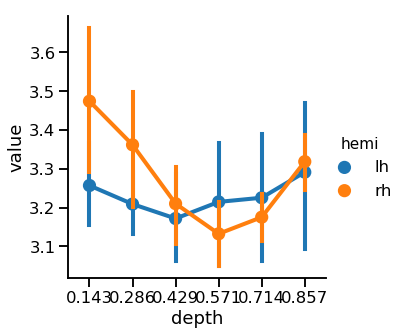

In [254]:
tmp = max_wl.loc[:, (max_wl.mean() < 6)].T.groupby(['subject', 'session', 'hemi'],).mean()
tmp = tmp.reset_index().melt(id_vars=tmp.index.names)
sns.catplot('depth', 'value', hue='hemi', data=tmp, ci=67, kind='point')

In [255]:
sns.set_context('talk')

In [256]:
import matplotlib.pyplot as plt

/Users/gilles/miniconda3/envs/pycortex/lib/python3.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


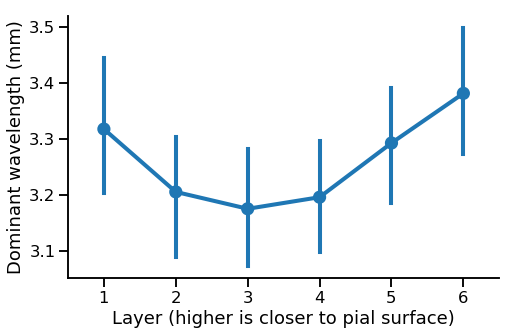

In [257]:
tmp = max_wl.copy()
ix = max_wl.index.tolist()
tmp.index = pd.Index([6 - ix.index(i) for i in ix], name='layer')
tmp = tmp.loc[:, (tmp.mean() < 6)].T.groupby(['subject', 'session'],).mean()
tmp = tmp.reset_index().melt(id_vars=tmp.index.names, value_name='Dominant wavelength (mm)')

tmp['Layer (higher is closer to pial surface)'] = tmp['layer']
sns.catplot('Layer (higher is closer to pial surface)', 'Dominant wavelength (mm)', data=tmp, ci=67, kind='point', size=5, aspect=1.5)

plt.savefig('/data/odc/figures/sf_depth.pdf', transparent=True)

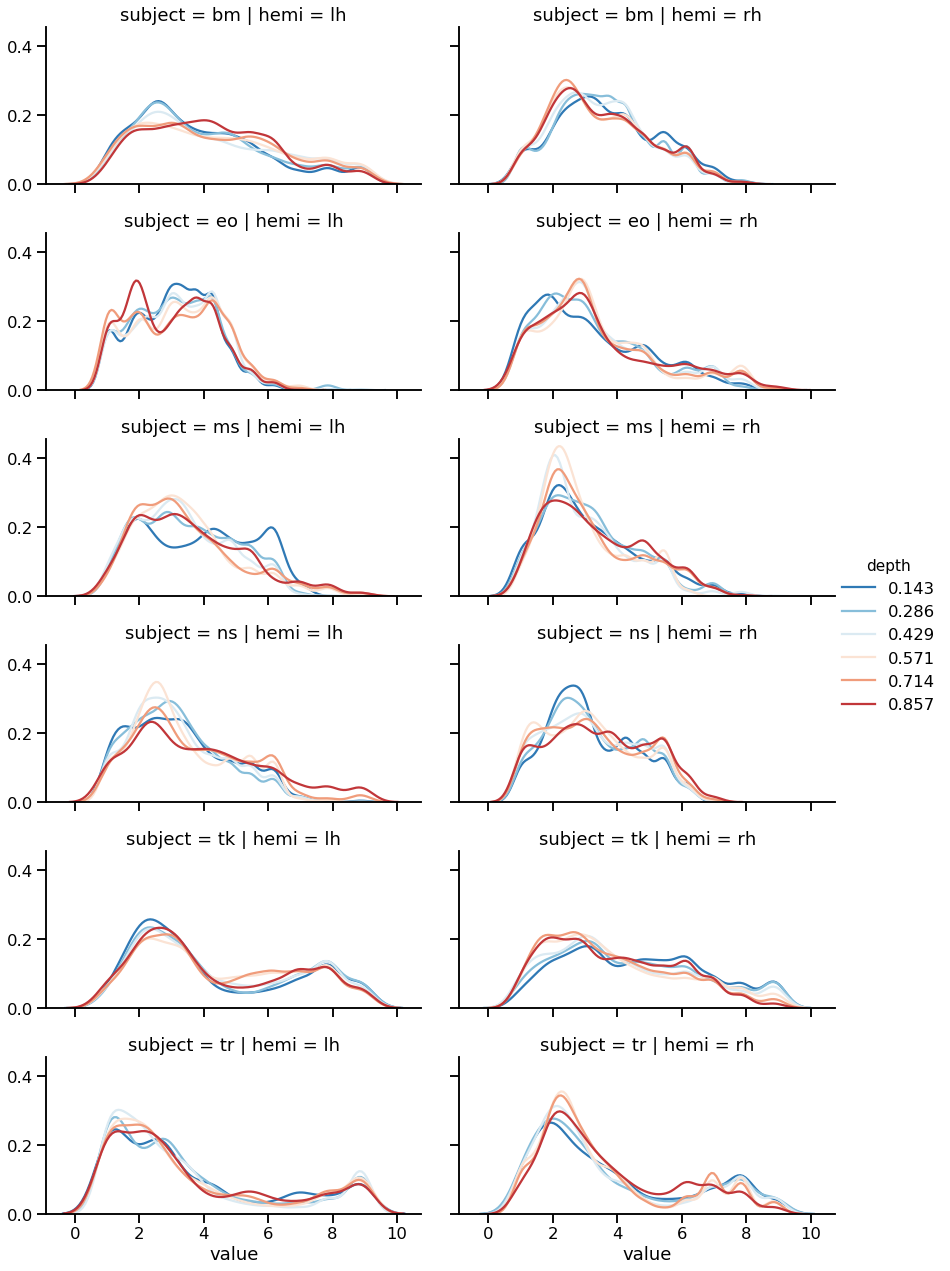

In [51]:
tmp = max_wl.reset_index().melt(id_vars='depth')

fac = sns.FacetGrid(data=tmp[tmp.value < 9.5], 
                    col='hemi', 
                    row='subject',
                    hue='depth', aspect=2, palette='RdBu_r',
                   )

fac.map(sns.distplot, 'value', hist=False)
fac.add_legend()

In [258]:
tmp = max_wl.loc[:, (max_wl.mean() < 9)].T
tmp = tmp.reset_index().melt(id_vars=tmp.index.names)
# sns.catplot('depth', 'value', hue='hemi', data=tmp, ci=67, kind='point')

In [259]:
fns = glob.glob('/data/odc/derivatives/sampled_giis/sub-*/ses-*/func/sub-*_ses-*_left_over_right_desc-zmap-depth-*_hemi-*.gii')

In [260]:
import numpy as np

In [261]:
from nilearn import surface

In [262]:
reg = re.compile('.*/sub-(?P<subject>.+)/ses-(?P<session>.+)/func/sub-(.+)_ses-[a-z0-9]{3,4}_left_over_right_desc-zmap-depth-(?P<depth>0\.[0-9]+)_hemi-(?P<hemi>lh|rh).gii')


idx = []

zmaps = []
for fn in fns[:]:
    
    meta = reg.match(fn).groupdict()
    
    z = surface.load_surf_data(fn)
    z = pd.DataFrame(z[np.newaxis, :], columns=np.arange(len(z)))
    
    mask = get_vertex_mask(meta['subject'], meta['hemi'])    
    ix = z.columns.intersection(mask)
    z = z.loc[:, ix]
    
    print('{}/{} V1 vertices have z-value ({}, {}, {})'.format(len(ix), len(mask), meta['subject'], meta['session'], meta['hemi'], meta['depth']))
    
    zmaps.append(z)
    idx.append(meta)

zmaps = pd.concat(zmaps, 
                  keys=[(d['subject'], d['session'], d['hemi'], d['depth']) for d in idx], 
                  names=['subject', 'session', 'hemi', 'depth', 'vertex'],
                  axis=1)

6597/6597 V1 vertices have z-value (bm, odc, lh)
4628/4628 V1 vertices have z-value (bm, odc, rh)
6597/6597 V1 vertices have z-value (bm, odc, lh)
4628/4628 V1 vertices have z-value (bm, odc, rh)
6597/6597 V1 vertices have z-value (bm, odc, lh)
4628/4628 V1 vertices have z-value (bm, odc, rh)
6597/6597 V1 vertices have z-value (bm, odc, lh)
4628/4628 V1 vertices have z-value (bm, odc, rh)
6597/6597 V1 vertices have z-value (bm, odc, lh)
4628/4628 V1 vertices have z-value (bm, odc, rh)
6597/6597 V1 vertices have z-value (bm, odc, lh)
4628/4628 V1 vertices have z-value (bm, odc, rh)
9503/9503 V1 vertices have z-value (eo, odc, lh)
8879/8879 V1 vertices have z-value (eo, odc, rh)
9503/9503 V1 vertices have z-value (eo, odc, lh)
8879/8879 V1 vertices have z-value (eo, odc, rh)
9503/9503 V1 vertices have z-value (eo, odc, lh)
8879/8879 V1 vertices have z-value (eo, odc, rh)
9503/9503 V1 vertices have z-value (eo, odc, lh)
8879/8879 V1 vertices have z-value (eo, odc, rh)
9503/9503 V1 vertice

In [263]:
zmaps = zmaps.T


In [264]:
melted_z_values = zmaps.reset_index().melt(id_vars=zmaps.index.names, value_name='z-value').pivot_table(index='depth', 
                                                                columns=['subject', 'session', 'hemi', 'vertex'],
                                                                                           values='z-value')

In [265]:
df = pd.concat((max_wl, melted_z_values), keys=['max_wl', 'z-value'], names=['type'])

In [266]:
tmp = df.reset_index().melt(df.index.names)
df = tmp.pivot_table(index=['subject', 'session', 'hemi', 'vertex'], columns='type', values='value')

In [267]:
df['abs(z-value)'] = df['z-value'].abs()

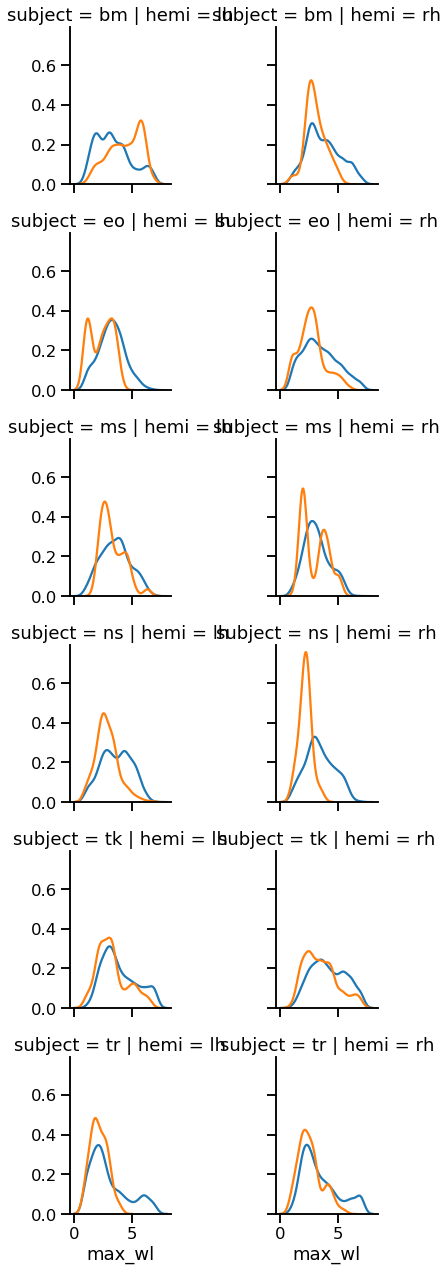

In [268]:
df2 = df.loc[(df['abs(z-value)'] > 2) & (~df['max_wl'].isnull()) & (df['max_wl'] < 7)]
df1 = df.loc[(df['abs(z-value)'] < 1) & (~df['max_wl'].isnull()) & (df['max_wl'] < 7)]

df_ = pd.concat((df1, df2), keys=['small z', 'high z'], names=['type'])
fac = sns.FacetGrid(df_.reset_index(), hue='type', col='hemi', row='subject')#, row#col_wrap=3)

fac.map(sns.distplot, 'max_wl', hist=False, kde_kws={'bw':.33})

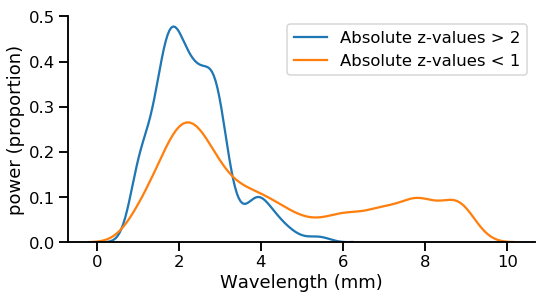

In [269]:
tmp = df.loc['tr']
tmp = tmp[(tmp['abs(z-value)'] > 2) & (tmp['max_wl'] < 9)]
sns.distplot(tmp.loc[~tmp['max_wl'].isnull(), 'max_wl'], hist=False, label='Absolute z-values > 2')


tmp = df.loc['tr']
tmp = tmp[(tmp['abs(z-value)'] < 1) & (tmp['max_wl'] < 9)]
sns.distplot(tmp.loc[~tmp['max_wl'].isnull(), 'max_wl'], hist=False, label='Absolute z-values < 1')

plt.legend()
sns.despine()
plt.xlabel('Wavelength (mm)')
plt.ylabel('power (proportion)')
plt.gcf().set_size_inches(8, 4.5)

plt.tight_layout()

plt.savefig('/data/odc/figures/sf_histogram.pdf', transparent=True)